### Model using New Data

In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None) # Show all the columns

In [2]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction-Part2/Dev/Data/df6.csv'
data = pd.read_csv(url)
data

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,110028.0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,119299.0,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,82113.0,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,96462.0,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,65725.0,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42897,86549.0,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
42898,102203.0,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
42899,60666.0,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,2.0,4.0,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0
42900,94171.0,23.0,2.0,192.0,2.0,1.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,4.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,1.0


# Data Preparation

## Standardization of Numeric Variables

In [3]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing Values

The satisfaction level of each feature should range from 1 to 5.

If the rating is 0, that means the customer did not rate for this feature.

In [4]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               
                print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

list_column_values(data, data.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.

In [5]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

#### We should consider rating=0 as missing values as the customer did not provide any rating feedback.

In [6]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.013868817304554566

#### Missing ratings only takes up 1.3% of the dataset, try advanced imputation techniques here

## KNN Imputation

In [7]:
#replace the 0 value as nan
data[incomplete] = data[incomplete].replace(0, np.nan)

In [8]:
data[incomplete].isnull().sum()

Inflight_wifi_service                162
Departure/Arrival_time_convenient    276
Ease_of_Online_booking               145
Online_boarding                        9
Leg_room_service                       3
dtype: int64

In [9]:
null_rows_idx = data.isnull().any(axis=1)

data.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,NaN,NaN,NaN,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,NaN,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,NaN,5.0,NaN,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [10]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

data_num = data.select_dtypes(include=[np.number])
imputer.fit(data_num)

X_ = imputer.transform(data_num)

#save in df4_knn
data_knn = pd.DataFrame(X_, columns=data_num.columns, index=data_num.index)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,3.6,3.6,2.8,3.0,2.0,5.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3.4,1.0,1.0,1.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3.0,5.0,3.0,4.0,2.0,5.0,5.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


#### Since the satisfaction level can only be 1,2,3,4, or 5. we need to conver the value to integer

In [11]:
import math

def ceil(x):
    return math.ceil(x - 0.5)

data_knn[incomplete] = data_knn[incomplete].applymap(ceil)

data_knn.loc[null_rows_idx].head(3)

,id,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
14,14849.0,-0.056376,0.0,-1.041118,4,4,3,3.0,2.0,5,3.0,4.0,4.0,4,4.0,4.0,4.0,3.0,-0.454514,1.0,1.0,1.0,1.0
66,85554.0,0.545156,0.0,-1.020660,3,1,1,1.0,3.0,4,5.0,4.0,4.0,4,4.0,4.0,4.0,5.0,-0.454514,1.0,0.0,1.0,1.0
342,48727.0,0.620348,0.0,2.036342,3,5,3,4.0,2.0,5,5.0,4.0,4.0,4,4.0,3.0,4.0,3.0,-0.454514,1.0,0.0,1.0,1.0


In [12]:
list_column_values(data_knn, data_knn.shape[1],'True')

**Results:**

id                        ==> more than 23 values
Age                       ==> more than 23 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 23 values
Inflight_wifi_service     ==> [1, 2, 3, 4, 5]
Departure/Arrival_time_convenient ==> [1, 2, 3, 4, 5]
Ease_of_Online_booking    ==> [1, 2, 3, 4, 5]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1, 2, 3, 4, 5]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1, 2, 3, 4, 5]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 23 values
satisfactio

## Splitting the Dataset

In [13]:
# Identify features and target
X = data_knn.drop(columns=['satisfaction'])
y = data_knn['satisfaction']

### Train Test Split

In [14]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(34321, 8581)

### Test Validation Split

In [15]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4290, 4291)

In [16]:
data_knn.columns

Index(['id', 'Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

## Data/Information Leakage Analysis

### Introduction:

Data leakage in machine learning refers to the unintended or improper use of data during model training or evaluation that can result in artificially inflated performance metrics or compromised model integrity. It occurs when information from the test or validation dataset, which is meant to be unseen by the model during training, is used inappropriately. Data leakage can lead to over-optimistic performance results during model development, as the model may have "seen" the test data before and learned to perform well on it, but may not generalize well to new, unseen data in real-world scenarios. Data leakage can arise from various sources, such as improperly combining training and test data, including information from the future, or using data that is not representative of the real-world deployment scenario. Detecting and mitigating data leakage is crucial to ensure the reliability and validity of machine learning models.

- ### Detection:

In [17]:
# Variable correlation
corr = data_knn.corr()['satisfaction'].sort_values()

print('Top 10 - Positive Correlations:')
print('-----------------------------------')
print(corr.tail(10))
print('\nTop 10 - Negative Correlations:')
print('------------------------------')
print(corr.head(10))

Top 10 - Positive Correlations:
-----------------------------------
Baggage_handling                  0.363072
Cleanliness                       0.378198
Flight_Distance                   0.397443
On-board_service                  0.447795
Leg_room_service                  0.482966
Seat_comfort                      0.499405
Inflight_entertainment            0.535067
Type_of_Travel_Business travel    0.639366
Online_boarding                   0.652242
satisfaction                      1.000000
Name: satisfaction, dtype: float64

Top 10 - Negative Correlations:
------------------------------
Class                               -0.718454
Departure/Arrival_time_convenient   -0.179432
Gate_location                       -0.026800
Gender_Male                         -0.015567
Departure_Delay_in_Minutes           0.019626
id                                   0.098392
Ease_of_Online_booking               0.120327
Inflight_wifi_service                0.165121
Food_and_drink                     

<AxesSubplot:>

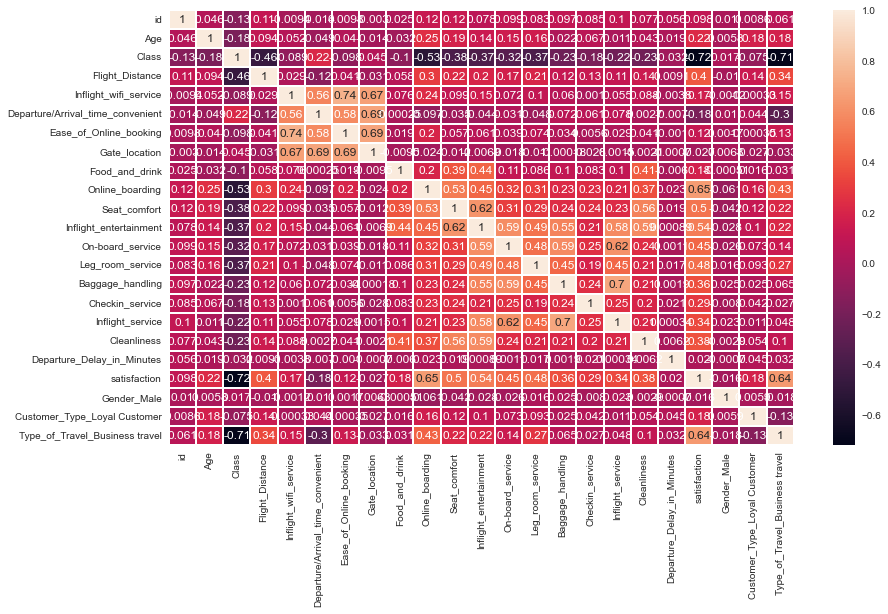

In [18]:
# Variable correlation plot
plt.figure(figsize=(14,8))
sns.heatmap(data_knn.corr(),annot = True, linewidths=.05)

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since preprocessing is involved, a pipeline is recommended for best practices
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X_train, y_train, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.980012


In [20]:
nonsatisfied_women = data_knn[(data_knn["satisfaction"] == 0) & (data_knn["Gender_Male"] == 0)]
fraction_nonsatisfied_women = round(nonsatisfied_women.shape[0] / data_knn.shape[0], 2)

satisfied_women = data_knn[(data_knn["satisfaction"] == 1) & (data_knn["Gender_Male"] == 0)]
fraction_satisfied_women = round(satisfied_women.shape[0] / data_knn.shape[0], 2)

print("Fraction of those non-satisfied women:", fraction_nonsatisfied_women)
print("Fraction of those satisfied women:", fraction_satisfied_women)
print("Two ratios are similar.")

Fraction of those non-satisfied women: 0.21
Fraction of those satisfied women: 0.29
Two ratios are similar.


In [21]:
nonsatisfied_business = data_knn[(data_knn["satisfaction"] == 0) & (data_knn["Class"] == 2)]
fraction_nonsatisfied_business = round(nonsatisfied_business.shape[0] / data_knn.shape[0], 2)

satisfied_business = data_knn[(data_knn["satisfaction"] == 1) & (data_knn["Class"] == 2)]
fraction_satisfied_business = round(satisfied_business.shape[0] / data_knn.shape[0], 2)

print("Fraction of those non-satisfied business:", fraction_nonsatisfied_business)
print("Fraction of those satisfied business:", fraction_satisfied_business)
print("The disparity between the two ratios is not substantial.")

Fraction of those non-satisfied business: 0.3
Fraction of those satisfied business: 0.03
The disparity between the two ratios is not substantial.


In [22]:
X_train2 = X_train.copy()
X_train2.drop(["Class"], axis=1, inplace=True)

# Since preprocessing is involved, a pipeline is recommended for best practices
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X_train2, y_train, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.978468


### Solution:

1. Remove high correlated features which detected as leaks

    After evaluating the correlation coefficients between the features and the target variable, the highest absolute value observed is 0.72, for the feature "Class" and the target variable "satisfaction". Considering that this correlation is not extremely high, we will not remove this variable immediately. Furthermore, despite removing this feature, there is no discernible impact on the cross-validation accuracy. However, since it still represents a relatively strong correlation that could potentially impact the model's performance, it should be considered noteworthy and handled carefully.
    

2. Create a separate validation set

    Creating a separate validation set in machine learning is valuable because it helps mitigate data leakage, ensures reliable model evaluation, robust model selection, accurate performance estimation, and enhanced model generalization. Keeping a separate validation set that is not used during model training allows for unbiased model evaluation on truly unseen data. It helps in accurately estimating model performance, selecting the best-performing model, and identifying models that are less likely to be affected by data leakage. Ultimately, a well-chosen and properly used validation set contributes to building more reliable and effective machine learning models.

### References:

1. Brownlee, J. (2020). Data Leakage in Machine Learning. MachineLearningMastery.com. https://machinelearningmastery.com/data-leakage-machine-learning/


2. Alexis, C. (2023). Data Leakage. Kaggle. https://www.kaggle.com/code/alexisbcook/data-leakage#Introduction


3. Goyal, C. (2021). Data Leakage And Its Effect On The Performance of An ML Model. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/07/data-leakage-and-its-effect-on-the-performance-of-an-ml-model/


4. Singh, P. (2022). Data Leakage in Machine Learning: How it can be detected and minimize the risk. Medium. https://towardsdatascience.com/data-leakage-in-machine-learning-how-it-can-be-detected-and-minimize-the-risk-8ef4e3a97562

## Dealing Imbalanced Data

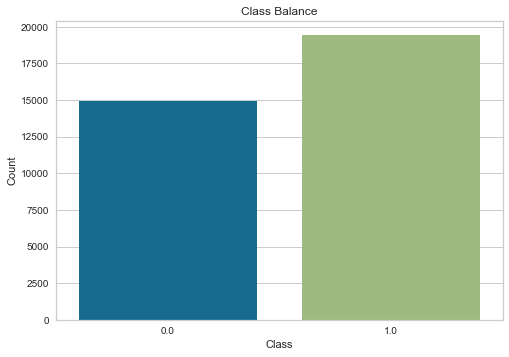

In [23]:
# We will graph the frequency of satisfied and non satisfied to see if the dataset is imbalanced
sns.countplot(x=y_train)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Balance")
plt.show()

#### Our dataset is not much inbalanced, but we still have more cases in which the client is satisfied which means much of satisfied cases.

### SMOTEENN

In [24]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_smoteen, y_train_smoteen = smote_enn.fit_resample(X_train, y_train)

In [25]:
y_train.value_counts()

1.0    19426
0.0    14895
Name: satisfaction, dtype: int64

In [26]:
y_train_smoteen.value_counts()

0.0    10776
1.0     9650
Name: satisfaction, dtype: int64

In [27]:
y_val.value_counts()

1.0    2375
0.0    1915
Name: satisfaction, dtype: int64

In [28]:
X_train = X_train_smoteen
y_train = y_train_smoteen